# Modelos Lineares


In [1]:
# @title Lendo a planilha

import numpy as np
import pandas as pd

df = pd.read_csv("dados.csv", index_col=0)

ciclos = df.index.values
t_feed = df["t_feed"].values
t_rinse = df["t_rinse"].values
t_blow = df["t_blow"].values
t_purge = df["t_purge"].values

purity_H2 = df["purity_H2"].values
H2_CO_ratio = df["H2_CO_ratio"].values
purity_CO2 = df["purity_CO2"].values
recovery_CO2 = df["recovery_CO2"].values
productivity = df["productivity"].values


In [2]:
# Colocando dados em desvio

y = np.array(
    [
        purity_H2,
        H2_CO_ratio,
        purity_CO2,
        recovery_CO2,
        productivity,
    ]
).T
u = np.array([t_feed, t_rinse, t_blow, t_purge]).T

# ciclo de referência
ref_idx = 1
y_ref = np.tile(y[ref_idx, :], (len(y), 1))
u_ref = np.tile(u[ref_idx, :], (len(u), 1))

# --- Calcular desvios ---
y_desvio = y - y_ref
u_desvio = u - u_ref


# Gerando modelos lineares


# ARX


In [3]:
def gerar_ARX(y, u):
    # Construindo a matriz de regressão
    X = np.hstack([y[:-1, :], u[:-1, :]])

    # Saídas futuras
    Y = y[1:, :]

    # Estimando parâmetros via mínimos quadrados
    theta = np.linalg.lstsq(X, Y)[0]
    return theta


theta = gerar_ARX(y_desvio, u_desvio)

print("Parâmetros estimados:\n", theta)

# Simulando saída estimada
N = len(y_desvio)

y_arx = np.zeros_like(y_desvio)
y_arx[0] = y_desvio[0]  # inicializa com o primeiro valor real

for k in range(1, N):
    phi = np.concatenate([y_arx[k - 1], u_desvio[k - 1]])
    y_arx[k] = phi @ theta

y_arx = y_arx + y_ref  # Convertendo o valor desvio em variavel de engenharia


Parâmetros estimados:
 [[ 8.37162094e-01  3.18948946e-02  4.84291650e-02  5.37295720e+00
   1.39197996e-01]
 [ 1.79476417e+01  3.70370477e+00 -4.50607647e+01  2.04553365e+02
   1.30200630e+01]
 [-4.10919698e-01 -9.56715708e-02  1.35667942e+00 -5.72855842e+00
  -3.77551967e-01]
 [ 2.60452852e-01  5.62436468e-02 -4.00192267e-01  2.63757691e+00
   1.79763093e-01]
 [-3.59327515e-01 -2.86715493e-01 -1.98389933e+00  1.81613080e+01
   2.36211515e-01]
 [ 2.42584870e-02  5.94474310e-03 -4.48390919e-02  3.06665893e-01
   2.23647795e-02]
 [ 7.29344281e-02  1.42433242e-02 -1.38353618e-01  1.11474766e+00
   5.89515243e-02]
 [-9.69410479e-03 -2.88834850e-03 -8.09093204e-03 -6.16069650e-02
  -1.16023911e-02]
 [-8.04554585e-02 -2.02813004e-02  1.29847573e-01 -1.25447171e+00
  -8.02302781e-02]]


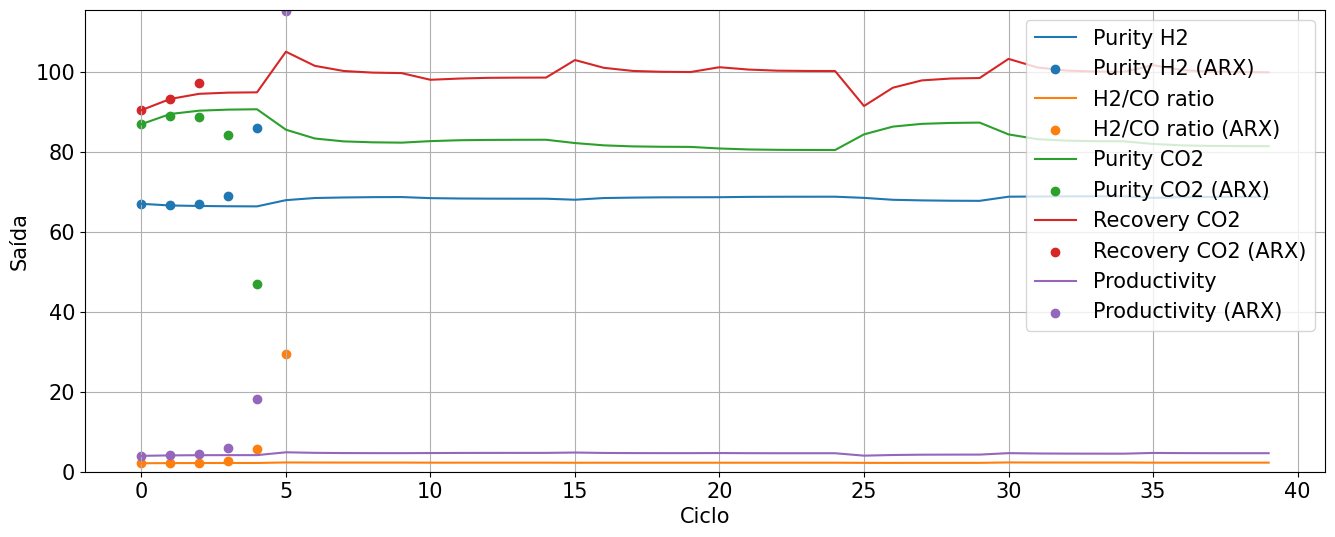

In [4]:
# Plotando resultados
from lib.plot import plot_comparison

plot_comparison(ciclos, y, y_arx, "ARX")


## Espaço de estados


In [5]:
A = theta[:5, :].T
B = theta[5:, :].T
C = np.eye(5)
D = np.zeros((5, 4))

x = y_desvio[0].copy()  # inicializa com a primeira saída
y_ss = np.zeros_like(y_desvio)
y_ss[0] = x

for k in range(1, N):
    x = A @ x + B @ u_desvio[k - 1]
    y_ss[k] = C @ x + D @ u_desvio[k - 1]

y_ss = y_ss + y_ref  # Convertendo o valor desvio em variavel de engenharia


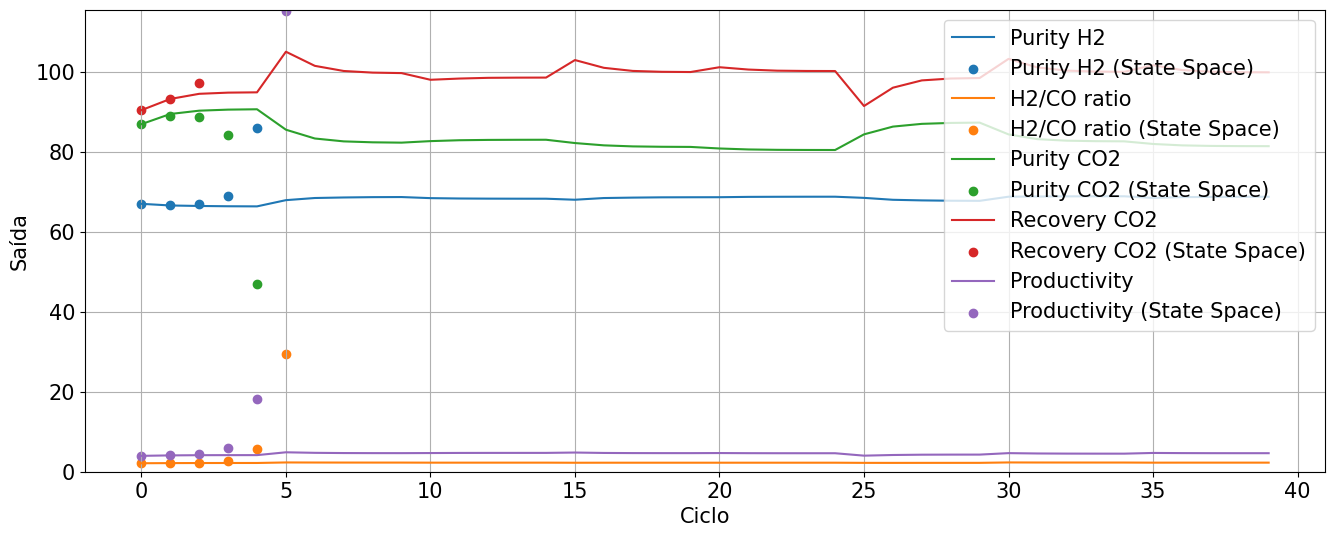

A: [[ 8.37162094e-01  1.79476417e+01 -4.10919698e-01  2.60452852e-01
  -3.59327515e-01]
 [ 3.18948946e-02  3.70370477e+00 -9.56715708e-02  5.62436468e-02
  -2.86715493e-01]
 [ 4.84291650e-02 -4.50607647e+01  1.35667942e+00 -4.00192267e-01
  -1.98389933e+00]
 [ 5.37295720e+00  2.04553365e+02 -5.72855842e+00  2.63757691e+00
   1.81613080e+01]
 [ 1.39197996e-01  1.30200630e+01 -3.77551967e-01  1.79763093e-01
   2.36211515e-01]]
B: [[ 0.02425849  0.07293443 -0.0096941  -0.08045546]
 [ 0.00594474  0.01424332 -0.00288835 -0.0202813 ]
 [-0.04483909 -0.13835362 -0.00809093  0.12984757]
 [ 0.30666589  1.11474766 -0.06160696 -1.25447171]
 [ 0.02236478  0.05895152 -0.01160239 -0.08023028]]
C: [[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
D: [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [6]:
# Plotando resultados
plot_comparison(ciclos, y, y_ss, "State Space")

print("A:", A)
print("B:", B)
print("C:", C)
print("D:", D)
